# Tracing

In [ ]:
import os
from google.colab import userdata

os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "default"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "PUT YOURS HERE"

# Getting started

Let's invoke the Gemini with a simple text input:

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
google_api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=google_api_key)

In [ ]:
from langchain_core.runnables import Runnable
isinstance(llm, Runnable)

True

In [ ]:
result = llm.invoke("What is the capital of the USA?")
print(result.content)

The capital of the USA is **Washington, D.C.**


In [ ]:
result.content

'The capital of the USA is **Washington, D.C.**'

In [ ]:
print(result.usage_metadata)

{'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 29}}


In [ ]:
from langchain_core.messages import HumanMessage

user_input = HumanMessage(content="What is the capital of the USA?")

In [ ]:
step1 = llm.invoke([user_input])

In [ ]:
type(step1)

langchain_core.messages.ai.AIMessage

In [ ]:
print(step1.content)

The capital of the USA is **Washington, D.C.**


In [ ]:
print(step1.usage_metadata)

{'input_tokens': 9, 'output_tokens': 31, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 18}}


In [ ]:
from langchain_core.prompts import PromptTemplate

prompt_template = (
    "Be concise and answer user's question carefully.\n\n"
    "QUESTION:\n{question}\n"
)

question = "What is the capital of the USA?"
lc_prompt_template = PromptTemplate.from_template(prompt_template)
lc_prompt_template.invoke({"question": question})

StringPromptValue(text="Be concise and answer user's question carefully.\n\nQUESTION:\nWhat is the capital of the USA?\n")

In [ ]:
from langchain_core.output_parsers import StrOutputParser

chain = lc_prompt_template | llm | StrOutputParser()
result = chain.invoke({"question": question})

In [ ]:
type(result)

str

A special placeholder for messages:

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import SystemMessagePromptTemplate


msg_template = HumanMessagePromptTemplate.from_template(prompt_template)
msg_example = msg_template.format(question=question)

print(msg_example)


content="Be concise and answer user's question carefully.\n\nQUESTION:\nWhat is the capital of the USA?\n" additional_kwargs={} response_metadata={}


In [ ]:
chat_prompt_template = ChatPromptTemplate.from_messages([SystemMessage(content="You are a helpful assistant."), msg_template])
chain = chat_prompt_template | llm | StrOutputParser()
chain.invoke({"question": question})

'Washington, D.C.'

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

chat_prompt_template = ChatPromptTemplate.from_messages(
    [("system", "You are a helpful assistant."),
     ("placeholder", "{history}"),
     # same as MessagesPlaceholder("history"),
     ("human", prompt_template)])

In [ ]:
chat_prompt_template.invoke(question)

ChatPromptValue(messages=[SystemMessage(content='You are a helpful assistant.', additional_kwargs={}, response_metadata={}), HumanMessage(content="Be concise and answer user's question carefully.\n\nQUESTION:\nWhat is the capital of the USA?\n", additional_kwargs={}, response_metadata={})])

In [ ]:
len(chat_prompt_template.invoke(question).messages)

2

In [ ]:
len(chat_prompt_template.invoke({"question": question, "history": [("user", "hi"), ("ai", "how can I help?")]}).messages)

4

In [ ]:
def increment_by_one(x: int) -> int:
 return x + 1


def fake_llm(x: int) -> str:
 return f"Result = {x}"

In [ ]:
from langchain_core.runnables import RunnableLambda

chain = (
   increment_by_one | RunnableLambda(fake_llm)
)


result = chain.invoke(1)
print(result)

Result = 2


In [ ]:
from langchain_core.runnables import RunnableSequence


a = increment_by_one | RunnableLambda(fake_llm)
b = RunnableSequence(RunnableLambda(increment_by_one), RunnableLambda(fake_llm))

print(a == b)


True


In [ ]:
from langchain_core.callbacks import UsageMetadataCallbackHandler

cb = UsageMetadataCallbackHandler()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", google_api_key=google_api_key, callbacks=[cb])

In [ ]:
chain = lc_prompt_template | llm | StrOutputParser()
chain.invoke({"question": question})

'Washington, D.C.'

In [ ]:
print(cb)

{'gemini-2.0-flash-001': {'input_tokens': 23, 'output_tokens': 7, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}}


# Intro to LangGraph

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END

class CustomState(TypedDict):
    a: int
    b: int
    result: int


def _node_a(state):
    return {"a": 1}

def _node_b(state):
    return {"b": 2}

def _node_sum(state):
    a = state["a"]
    b = state["b"]
    return {"result": a+b}

builder = StateGraph(CustomState)
builder.add_node("node_a", _node_a)
builder.add_node("node_b", _node_b)
builder.add_node("node_sum", _node_sum)

builder.add_edge(START, "node_a")
builder.add_edge(START, "node_b")
builder.add_edge("node_a", "node_sum")
builder.add_edge("node_b", "node_sum")
builder.add_edge("node_sum", END)

workflow = builder.compile()

from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
for event in workflow.stream({}, stream_mode="values"):
  print(event)

{'a': 1, 'b': 2}
{'a': 1, 'b': 2, 'result': 3}


In [ ]:
from typing import Literal


class CustomState(TypedDict):
    operation: str
    a: int
    b: int
    result: int

def _node_multiply(state):
    a = state["a"]
    b = state["b"]
    return {"result": a*b}

def _edge(state) -> Literal["node_sum", "node_multiply"]:
    if state["operation"] == "sum":
      return "node_sum"
    return "node_multiply"

builder = StateGraph(CustomState)
builder.add_node("node_a", _node_a)
builder.add_node("node_b", _node_b)
builder.add_node("node_sum", _node_sum)
builder.add_node("node_multiply", _node_multiply)

builder.add_edge(START, "node_a")
builder.add_edge(START, "node_b")
builder.add_conditional_edges("node_a", _edge)
builder.add_conditional_edges("node_b", _edge)
builder.add_edge("node_sum", END)
builder.add_edge("node_multiply", END)

workflow = builder.compile()

from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
initial_state = {"operation": "add"}
for event in workflow.stream(initial_state, stream_mode="values"):
  print(event)

{'operation': 'add'}
{'operation': 'add', 'a': 1, 'b': 2}
{'operation': 'add', 'a': 1, 'b': 2, 'result': 2}


In [ ]:
for event in workflow.stream({'operation': 'multiply'}, stream_mode="values"):
  print(event)

{'operation': 'multiply'}
{'operation': 'multiply', 'a': 1, 'b': 2}
{'operation': 'multiply', 'a': 1, 'b': 2, 'result': 2}


In [ ]:
result = await workflow.ainvoke(initial_state)
print(result)

{'operation': 'add', 'a': 1, 'b': 2, 'result': 2}


Now, let's take at reducers. We saw the default reducer - it replaces the value in the state. Another option is to use a built-in reducer, for example `add` with a list:

In [ ]:
from operator import add

add([1, 2], [3])

[1, 2, 3]

In [ ]:
from operator import add
from typing import Annotated

class CustomState(TypedDict):
    values: Annotated[list[int], add]
    result: int


def _node_a(state):
    return {"values": [1]}

def _node_b(state):
    return {"values": [2]}

def _node_sum(state):
    return {"result": sum(state["values"])}

builder = StateGraph(CustomState)
builder.add_node("node_a", _node_a)
builder.add_node("node_b", _node_b)
builder.add_node("node_sum", _node_sum)

builder.add_edge(START, "node_a")
builder.add_edge("node_a", "node_b")
builder.add_edge("node_b", "node_sum")
builder.add_edge("node_sum", END)

workflow = builder.compile()

from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
for event in workflow.stream({}, stream_mode="values"):
  print(event)

{'values': [1]}
{'values': [1, 2]}
{'values': [1, 2], 'result': 3}


Now, let's take a look at custom reducers:

In [ ]:
def my_reducer(left: int, right: int) -> int:
  if right:
    return left + right
  return left

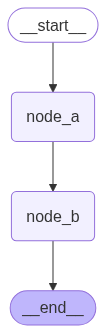

In [ ]:
from operator import add
from typing import Annotated

class CustomState(TypedDict):
    value: Annotated[int, my_reducer]


def _node_a(state):
    return {"value": 1}

def _node_b(state):
    return {"value": 2}

builder = StateGraph(CustomState)
builder.add_node("node_a", _node_a)
builder.add_node("node_b", _node_b)

builder.add_edge(START, "node_a")
builder.add_edge("node_a", "node_b")
builder.add_edge("node_b", END)

workflow = builder.compile()

from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [ ]:
for event in workflow.stream({}, stream_mode="values"):
  print(event)

{'values': [1]}
{'values': [1, 2]}
{'values': [1, 2], 'result': 3}


In [ ]:
step2 = llm.invoke([user_input, step1, ("human", "How many people live there?")])

In [ ]:
print(step2.content)

The population of Washington, D.C. is estimated to be around **689,545** as of 2020.


# Tracing

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", google_api_key=google_api_key)
result = llm.invoke("What is the capital of the USA?")
print(result.content)

The capital of the USA is **Washington, D.C.**


In [ ]:
from langsmith import traceable

@traceable
def run():
  return llm.invoke("What is the capital of the USA?")

In [ ]:
from langsmith import Client, tracing_context, traceable
from langsmith.wrappers import wrap_openai

langsmith_client = Client(
  api_key=userdata.get('LANGSMITH_API_KEY'),
  api_url="https://api.smith.langchain.com"
)

In [ ]:
with tracing_context(enabled=True):
  result = llm.invoke("What is the capital of the USA?")

In [ ]:
result = llm.invoke("What is the capital of UK?")

# Using external tools

In [ ]:
from langchain_core.prompts import PromptTemplate


Let's demonstrate how we can instruct an LLM to use an external tool:

In [ ]:
task = (
    "In 1990, the average cost of a gallon of gasoline was $1.16. If the "
    "inflation rate from 1990 to today has been a cumulative 180%, what would "
    "that gallon of gas cost in today's money? How does that compare to the "
    "current average price of gas?"
)

raw_prompt_template = (
  "You have access to search engine that provides you an "
  "information about current events. "
  "Given the question, decide whether you need an additional "
  "information from the search engine, and if yes, reply with 'SEARCH: "
   "<generated query>'. Only if you know enough to answer the user "
   "then reply with 'RESPONSE <final response>').\n"
   "Now, act to answer a user question:\n{question}"
)
prompt_template = PromptTemplate.from_template(raw_prompt_template)

response = (prompt_template | llm).invoke(task)
print(response.content)

SEARCH: average gas price today


Technical note: a _PromptTemplate_ allows you substitute variables when executing the chain:

In [ ]:
prompt_template.invoke({"question": "TEST"})

StringPromptValue(text="You have access to search engine that provides you an information about current events. Given the question, decide whether you need an additional information from the search engine, and if yes, reply with 'SEARCH: <generated query>'. Only if you know enough to answer the user then reply with 'RESPONSE <final response>').\nNow, act to answer a user question:\nTEST")

In [ ]:
query = "average gas price today"
search_result = "3.349"

In [ ]:
raw_prompt_template = (
  "You have access to search engine that provides you an "
  "information about current events. "
  "Given the question, decide whether you need an additional "
  "information from the search engine, and if yes, reply with 'SEARCH: "
   "<generated query>'. Only if you know enough to answer the user "
   "then reply with 'RESPONSE <final response>').\n"
   #"Today is {date}."
   "Now, act to answer a user question and "
   "take into account your previous actions:\n"
   "HUMAN: {question}\n"
   "AI: SEARCH: {query}\n"
   "RESPONSE FROM SEARCH: {search_result}\n"
)
prompt_template = PromptTemplate.from_template(raw_prompt_template)

result = (prompt_template | llm).invoke({"question": task, "query": query, "search_result": search_result, "date": "Feb 2025"})
print(result.content)

RESPONSE: With a cumulative inflation rate of 180% from 1990, a gallon of gas that cost $1.16 in 1990 would cost $3.25 in today's money (1.16 * 2.80 = 3.248). The current average price of gas is $3.35, which is about 10 cents more than the inflation-adjusted price from 1990.


# Creating tools with LangChain

Let's use a DuckDuckGo search through LangChain:

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()
print(f"Tool's name = {search.name}")
print(f"Tool's name = {search.description}")
print(f"Tool's arg schema = {search.args_schema}")

Tool's name = duckduckgo_search
Tool's name = A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.
Tool's arg schema = <class 'langchain_community.tools.ddg_search.tool.DDGInput'>


In [ ]:
from langchain_community.tools.ddg_search.tool import DDGInput

print(DDGInput.model_fields)

{'query': FieldInfo(annotation=str, required=True, description='search query to look up')}


In [ ]:
query = "What is the weather in Munich like tomorrow?"
search_input = DDGInput(query=query)
result = search.invoke(search_input.model_dump())
print(result)

Everything you need to know about tomorrow ' s weather in Munich , Bavaria, Germany. High/Low, Precipitation Chances, Sunrise/Sunset, and tomorrow 's Temperature History. Aug 28, 2025 · Munich , Germany - Detailed weather forecast for tomorrow . Hourly forecast for tomorrow - including weather conditions, temperature, pressure, humidity, precipitation, dewpoint, wind, visibility, and UV index data. 3 days ago · Get the latest hourly weather updates for Munich tomorrow . Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about tomorrow 's weather conditions in Munich . Aug 27, 2025 · Latest weather forecast for Munich for tomorrow 's, hourly weather forecast, including tomorrow 's temperatures in Munich , wind, rain and more. Current weather in Munich and forecast for today, tomorrow , and next 14 days Nov 27, 2024 · Geomagnetic activity Kp index tomorrow Forecast of geomagnetic activity for tomorrow . Three-hour forecast of the Kp planetary index The

In [ ]:
isinstance(result, str)

True

Another example - let's use a web API to instruct an LLM to get the latest information about FX rates:

In [ ]:
api_spec = """
openapi: 3.0.0
info:
  title: Frankfurter Currency Exchange API
  version: v1
  description: API for retrieving currency exchange rates. Pay attention to the base currency and change it if needed.

servers:
  - url: https://api.frankfurter.dev/v1

paths:
  /v1/{date}:
    get:
      summary: Get exchange rates for a specific date.
      parameters:
        - in: path
          name: date
          schema:
            type: string
            pattern: '^\d{4}-\d{2}-\d{2}$' # YYYY-MM-DD format
          required: true
          description: The date for which to retrieve exchange rates.  Use YYYY-MM-DD format.  Example: 2009-01-04
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: GBP,USD,EUR

  /v1/latest:
    get:
      summary: Get the latest exchange rates.
      parameters:
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: CHF,GBP
        - in: query
          name: base
          schema:
            type: string
          description: The base currency for the exchange rates. If not provided, EUR is used as a base currency. Example: USD
"""

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2022118673.py:20: SyntaxWarning: invalid escape sequence '\d'
  pattern: '^\d{4}-\d{2}-\d{2}$' # YYYY-MM-DD format


In [ ]:
from langchain_community.agent_toolkits.openapi.toolkit import RequestsToolkit
from langchain_community.utilities.requests import TextRequestsWrapper

toolkit = RequestsToolkit(
    requests_wrapper=TextRequestsWrapper(headers={}),
    allow_dangerous_requests=True,
)

for tool in toolkit.get_tools():
  print(tool.name)

requests_get
requests_post
requests_patch
requests_put
requests_delete


In [ ]:
from langgraph.prebuilt import create_react_agent

system_message = (
  "You're given the API spec:\n{api_spec}\n"
  "If possible, use this API if a user asks about foreign exchange rates. "
)

agent = create_react_agent(llm, toolkit.get_tools(), prompt=system_message.format(api_spec=api_spec))

In [ ]:
query = "What is the swiss franc to US dollar exchange rate?"

for event in agent.stream({"messages": [("human", query)]}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the swiss franc to US dollar exchange rate?
================================== Ai Message ==================================
Tool Calls:
  requests_get (7294e79c-7a71-4276-a7aa-636e8be4aff4)
 Call ID: 7294e79c-7a71-4276-a7aa-636e8be4aff4
  Args:
    url: https://api.frankfurter.dev/v1/latest?symbols=USD&base=CHF
================================= Tool Message =================================
Name: requests_get

{"amount":1.0,"base":"CHF","date":"2025-09-04","rates":{"USD":1.2413}}
================================== Ai Message ==================================

The current exchange rate is 1 CHF = 1.2413 USD.


In [ ]:
response = llm.invoke([
    ("system", system_message.format(api_spec=api_spec)),
     ("human", "What is the swiss franc to US dollar exchange rate?")], tools=toolkit.get_tools())

In [ ]:
tool_calls = response.tool_calls
print(tool_calls)

[{'name': 'requests_get', 'args': {'__arg1': 'https://api.frankfurter.dev/v1/latest?symbols=USD&base=CHF'}, 'id': '3aae0067-0560-4a53-9baf-23f73621d4da', 'type': 'tool_call'}]


In [ ]:
toolkit.get_tools()[0].run(tool_calls[0]["args"]["__arg1"])

'{"amount":1.0,"base":"CHF","date":"2025-09-04","rates":{"USD":1.2413}}'

# Defining tools with LangChain

In [ ]:
import math
from langchain_core.tools import tool
import numexpr as ne

@tool
def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers.

    Always add * to operations, examples:
      73i -> 73*i
      7pi**2 -> 7*pi**2
    """
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)

In [ ]:
calculator.invoke("2+2")

'4'

In [ ]:
from langchain_core.tools import BaseTool

assert isinstance(calculator, BaseTool)
print(f"Tool name: {calculator.name}")
print(f"Tool name: {calculator.description}")
print(f"Tool schema: {calculator.args_schema.model_json_schema()}")

Tool name: calculator
Tool name: Calculates a single mathematical expression, incl. complex numbers.

    Always add * to operations, examples:
      73i -> 73*i
      7pi**2 -> 7*pi**2
Tool schema: {'description': 'Calculates a single mathematical expression, incl. complex numbers.\n\nAlways add * to operations, examples:\n  73i -> 73*i\n  7pi**2 -> 7*pi**2', 'properties': {'expression': {'title': 'Expression', 'type': 'string'}}, 'required': ['expression'], 'title': 'calculator', 'type': 'object'}


In [ ]:
print(calculator.args_schema.model_json_schema())

{'description': 'Calculates a single mathematical expression, incl. complex numbers.\n\nAlways add * to operations, examples:\n  73i -> 73*i\n  7pi**2 -> 7*pi**2', 'properties': {'expression': {'title': 'Expression', 'type': 'string'}}, 'required': ['expression'], 'title': 'calculator', 'type': 'object'}


In [ ]:
query = "How much is 2+3i squared?"

agent = create_react_agent(llm, [calculator])

for event in agent.stream({"messages": [("user", query)]}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How much is 2+3i squared?
================================== Ai Message ==================================
Tool Calls:
  calculator (2ce06133-d609-4393-a75e-d8bcb7d7d322)
 Call ID: 2ce06133-d609-4393-a75e-d8bcb7d7d322
  Args:
    expression: (2+3*i)**2
================================= Tool Message =================================
Name: calculator

(-5+12j)
================================== Ai Message ==================================

(2+3i)^2 is -5+12j.


In [ ]:
question = (
    #"I ate 200g of chicken breast, 150g of broccoli, and 50g of brown rice for dinner. "
    "I ate 200g of chicken breast for dinner. "
    "How many total calories did I consume, and what percentage of my recommended daily "
    "protein intake does this meal provide if my recommended intake is 75g?"
)

system_hint = "Think step-by-step. Always use search tool to get the fresh information about events or public facts that can change over time. Always use calculator tool for math computations."

agent = create_react_agent(
    llm, [calculator, search],
    prompt=system_hint)

for event in agent.stream({"messages": [("user", question)]}, stream_mode="updates"):
    for _, event_values in event.items():
      for message in event_values["messages"]:
        message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (7fc8bed7-28b7-4926-bf60-f3432cf37eab)
 Call ID: 7fc8bed7-28b7-4926-bf60-f3432cf37eab
  Args:
    query: calories in 200g chicken breast
================================= Tool Message =================================
Name: duckduckgo_search

200 grams of chicken breast (Broilers or fryers, meat and skin, cooked, fried, batter) contains 520 Calories . The macronutrient breakdown is 14% carbs, 47% fat, and 39% protein. This has a relatively high calorie density, with 260 Calories per 100g. The following is nutritional content of a 100g serving of chicken breast prepared using different cooking methods: A 100g serving of chicken breast is approximately 3.53 ounces. To convert between grams (g) and ounces (oz), you can use the following conversion formulae: 1 ounce (oz) = 28.34 grams (g) 1 gram (g) = 0.035 ounces (oz) See full list on irastoworldhealth.com The nutritional conte

In [ ]:
from langchain_core.runnables import RunnableLambda, RunnableConfig
from langchain_core.tools import tool, convert_runnable_to_tool


def calculator(expression: str) -> str:
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)

calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    arg_types={"expression": "str"},
)

In [ ]:
llm.invoke("How much is (2+3i)**2", tools=[calculator_tool]).tool_calls[0]

{'name': 'calculator',
 'args': {'__arg1': '(2+3*i)**2'},
 'id': '6eb16c7a-4ca1-4488-b2c3-4af43d386ddc',
 'type': 'tool_call'}

In [ ]:
calculator_tool.invoke({"expression": "(2+3*i)**2"})

'(-5+12j)'

In [ ]:
agent = create_react_agent(llm, [calculator_tool])

for event in agent.stream({"messages": [("user", "How much is (2+3i)^2")]}, stream_mode="updates"):
    for _, event_values in event.items():
      for message in event_values["messages"]:
        message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  calculator (71deb34a-e1b5-4a5a-8981-dd1a350a803b)
 Call ID: 71deb34a-e1b5-4a5a-8981-dd1a350a803b
  Args:
    __arg1: (2+3*i)**2
================================= Tool Message =================================
Name: calculator

(-5+12j)
================================== Ai Message ==================================

(2+3i)^2 is -5+12j


In [ ]:
from langchain_core.tools import StructuredTool

def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers."""
    return str(ne.evaluate(expression.strip(), local_dict={}))

calculator_tool = StructuredTool.from_function(
    func=calculator,
    handle_tool_error=True
)

agent = create_react_agent(llm, [calculator_tool])

for event in agent.stream({"messages": [("user", "How much is (2+3i)^2")]}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How much is (2+3i)^2
================================== Ai Message ==================================
Tool Calls:
  calculator (bfb64e58-cc77-4814-b507-363a9460cc5e)
 Call ID: bfb64e58-cc77-4814-b507-363a9460cc5e
  Args:
    expression: (2+3i)^2
================================= Tool Message =================================
Name: calculator

Error: SyntaxError('invalid decimal literal', ('<expr>', 1, 4, '(2+3i)^2', 1, 4))
 Please fix your mistakes.
================================== Ai Message ==================================

I am sorry, I cannot calculate this expression because it contains a syntax error. Please provide a valid mathematical expression.


# Controlled generation

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from pydantic import BaseModel, Field

class Step(BaseModel):
    """A step that is a part of the plan to solve the task."""
    step: str = Field(description="Description of the step")

class Plan(BaseModel):
    """A plan to solve the task."""
    steps: list[Step]


prompt = PromptTemplate.from_template(
    "Prepare a step-by-step plan to solve the given task.\n"
    "TASK:\n{task}\n"
)


In [ ]:
llm1 = llm.with_structured_output(Plan)

In [ ]:
substituted_prompt = prompt.invoke("How to write a bestseller on Amazon about generative AI?")

In [ ]:
llm1.invoke(substituted_prompt)

Plan(steps=[Step(step='Step 1: Research current bestsellers in the AI and technology categories on Amazon. Analyze their writing style, target audience, and topics covered.'), Step(step="Step 2: Identify a unique angle or niche within generative AI that isn't already saturated in the market. Consider focusing on a specific application, ethical implications, or future trends."), Step(step='Step 3: Develop a detailed outline for the book, including chapter titles, subheadings, and key concepts to be covered. Ensure a logical flow and clear structure.'), Step(step='Step 4: Write the book, focusing on clear, concise language that is accessible to a broad audience. Use real-world examples, case studies, and practical applications to illustrate key concepts.'), Step(step='Step 5: Edit and proofread the book thoroughly to ensure accuracy, clarity, and grammatical correctness. Consider hiring a professional editor.'), Step(step="Step 6: Design an eye-catching cover that accurately reflects the

In [ ]:
chain = prompt | llm.with_structured_output(Plan)
result = chain.invoke("How to write a bestseller on Amazon about generative AI?")
assert isinstance(result, Plan)
print(f"Amount of steps: {len(result.steps)}")
for step in result.steps:
  print(step.step)
  break

Amount of steps: 12
Research current bestsellers in the AI and generative AI categories on Amazon to identify popular topics, writing styles, and keywords.


In [ ]:
type(Plan)

pydantic._internal._model_construction.ModelMetaclass

In [ ]:
for step in result.steps:
  print(step.step)

Research current bestsellers in the AI and generative AI categories on Amazon to identify popular topics, writing styles, and keywords.
Define the target audience and tailor the book's content and language to their level of understanding and interests.
Develop a unique angle or perspective on generative AI that differentiates the book from existing literature.
Create a detailed outline of the book, covering key concepts, applications, and potential future developments in generative AI.
Write engaging and informative content, incorporating real-world examples, case studies, and practical tips.
Optimize the book for Amazon's search algorithm by using relevant keywords in the title, subtitle, and description.
Design an eye-catching cover that accurately reflects the book's content and appeals to the target audience.
Format the book for Kindle and paperback versions, ensuring readability and accessibility on various devices.
Proofread and edit the book thoroughly to eliminate errors and im

In [ ]:
Plan.model_json_schema()

{'$defs': {'Step': {'description': 'A step that is a part of the plan to solve the task.',
   'properties': {'step': {'description': 'Description of the step',
     'title': 'Step',
     'type': 'string'}},
   'required': ['step'],
   'title': 'Step',
   'type': 'object'}},
 'description': 'A plan to solve the task.',
 'properties': {'steps': {'items': {'$ref': '#/$defs/Step'},
   'title': 'Steps',
   'type': 'array'}},
 'required': ['steps'],
 'title': 'Plan',
 'type': 'object'}

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
from langchain_google_vertexai import ChatVertexAI
llm1 = ChatVertexAI(model_name="gemini-2.5-pro", project="kuligin-sandbox1")

plan_schema = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
          "properties": {
              "step": {"type": "STRING"},
          },
      },
}

query = "How to write a bestseller on Amazon about generative AI?"
result = (prompt | llm1.with_structured_output(schema=plan_schema, method="json_mode")).invoke(query)

In [ ]:
assert(isinstance(result, list))
print(f"Amount of steps: {len(result)}")
print(result[0])

Amount of steps: 8
{'step': "Phase 1: Research and Niche Identification. Analyze current Amazon bestsellers in the 'AI' and 'Technology' categories. Identify gaps in the market, popular sub-topics (e.g., AI for business, ethics, prompt engineering), and define a specific target audience (e.g., marketers, developers, entrepreneurs)."}


In [ ]:
from langchain_core.output_parsers import JsonOutputParser
llm_json = ChatVertexAI(project="kuligin-sandbox1", model_name="gemini-2.5-pro",
                        response_mime_type="application/json",
                        response_schema=plan_schema)
result = (prompt | llm_json | JsonOutputParser()).invoke(query)
assert(isinstance(result, list))
print(f"Amount of steps: {len(result)}")
print(result[0])

Amount of steps: 9
{'step': 'Phase 1: Research and Niche Identification. Analyze existing generative AI books on Amazon to find a unique angle. Identify your target audience (e.g., beginners, business leaders, artists) and what specific problem your book will solve for them.'}


In [ ]:
from langchain_core.output_parsers import StrOutputParser
response_schema = {"type": "STRING", "enum": ["positive", "negative", "neutral"]}

prompt = PromptTemplate.from_template(
    "Classify the tone of the following customer's review:"
    "\n{review}\n"
)

review = "I like this movie!"
llm_enum = ChatVertexAI(project="kuligin-sandbox1", model_name="gemini-1.5-pro-002",
                        response_mime_type="text/x.enum",
                        response_schema=response_schema)
result = (prompt | llm_enum | StrOutputParser()).invoke(review)
print(result)

positive


In [ ]:
plan_schema = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
          "properties": {
              "step": {"type": "STRING"},
          },
      },
}

query = "How to write a bestseller on Amazon about generative AI?"
result = (prompt | llm.with_structured_output(schema=plan_schema, method="json_mode")).invoke(query)

In [ ]:
assert(isinstance(result, list))
print(f"Amount of steps: {len(result)}")
print(result[0])

Amount of steps: 1
{'step': 'Inquisitive'}


In [ ]:
from langchain_core.output_parsers import JsonOutputParser
llm_json = ChatVertexAI(model_name="gemini-2.5-pro", project="kuligin-sandbox1", response_mime_type="application/json", response_schema=plan_schema)
result = (prompt | llm_json | JsonOutputParser()).invoke(query)
assert(isinstance(result, list))
print(f"Amount of steps: {len(result)}")
print(result[0])

Amount of steps: 1
{'step': "The customer's tone is inquisitive and neutral, not a review of a product or service. They are asking a question seeking information or guidance."}


# Plan-and-solve agent

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

system_prompt_template = (
    "For the given task, come up with a step by step plan.\n"
    "This plan should involve individual tasks, that if executed correctly will "
    "yield the correct answer. Do not add any superfluous steps.\n"
    "The result of the final step should be the final answer. Make sure that each "
    "step has all the information needed - do not skip steps."
)
planner_prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt_template),
     ("user", "Prepare a plan how to solve the following task:\n{task}\n")])

planner = planner_prompt | ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", temperature=1.0, google_api_key=google_api_key
).with_structured_output(Plan)

In [ ]:
task = "Write a strategic one-pager of building an AI startup?"
plan = planner.invoke(task)

In [ ]:
plan

Plan(steps=["Define the AI startup's vision and mission, clearly articulating its core purpose and long-term goal, specifically what problem it aims to solve with AI.", 'Identify the specific, significant problem the AI startup will address, providing context on its impact and why existing solutions are inadequate.', 'Outline the AI-powered solution, describing the core AI technology or approach that will solve the identified problem, highlighting its innovative aspects and how it works at a high level.', 'Define the target market, identifying the ideal customer segment for the AI solution and estimating the market size or potential.', 'Articulate the competitive advantage, explaining what makes the AI startup unique and defensible, such as proprietary data, unique algorithms, specialized team expertise, or a novel application of AI.', 'Develop the business model, describing how the AI startup will generate revenue (e.g., SaaS, licensing, subscription, service fees).', 'Summarize the g

In [ ]:
from langchain.agents import load_tools

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", google_api_key=google_api_key)
tools = load_tools(
  tool_names=["ddg-search", "arxiv", "wikipedia"],
  llm=llm
)

In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState
from typing_extensions import TypedDict
from langgraph.managed import IsLastStep
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class StepState(AgentState):
  plan: str
  step: str
  task: str

system_prompt = (
    "You're a smart assistant that carefully helps to solve complex tasks.\n"
    " Given a general plan to solve a task and a specific step, work on this step. "
    " Don't assume anything, keep in minds things might change and always try to "
    "use tools to double-check yourself.\m"
    " Use a calculator for mathematical computations, use Search to gather"
    "for information about common facts, fresh events and news, use Arxiv to get "
    "ideas on recent research and use Wikipedia for common knowledge."
)

step_template = (
    "Given the task and the plan, try to execute on a specific step of the plan.\n"
    "TASK:\n{task}\n\nPLAN:\n{plan}\n\nSTEP TO EXECUTE:\n{step}\n"
)

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", step_template),
])

execution_agent = create_react_agent(model=llm, tools=tools+[calculator_tool], state_schema=StepState, prompt=prompt_template)

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-678506150.py:17: SyntaxWarning: invalid escape sequence '\m'
  "use tools to double-check yourself.\m"


In [ ]:
class PlanState(TypedDict):
    task: str
    plan: Plan
    past_steps: Annotated[list[str], add]
    final_response: str


def get_current_step(state: PlanState) -> int:
  """Returns the number of current step to be executed."""
  return len(state.get("past_steps", []))

def get_full_plan(state: PlanState) -> str:
  """Returns formatted plan with step numbers and past results."""
  full_plan = []
  for i, step in enumerate(state["plan"].steps):
    full_step = f"# {i+1}. Planned step: {step}\n"
    if i < get_current_step(state):
      full_step += f"Result: {state['past_steps'][i]}\n"
    full_plan.append(full_step)
  return "\n".join(full_plan)

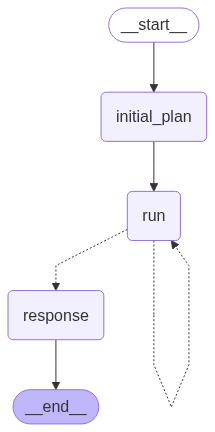

In [ ]:
final_prompt = PromptTemplate.from_template(
    "You're a helpful assistant that has executed on a plan."
    "Given the results of the execution, prepare the final response.\n"
    "Don't assume anything\nTASK:\n{task}\n\nPLAN WITH RESUlTS:\n{plan}\n"
    "FINAL RESPONSE:\n"
)

async def _build_initial_plan(state: PlanState) -> PlanState:
  plan = await planner.ainvoke(state["task"])
  return {"plan": plan}

async def _run_step(state: PlanState) -> PlanState:
  plan = state["plan"]
  current_step = get_current_step(state)
  step = await execution_agent.ainvoke({"plan": get_full_plan(state), "step": plan.steps[current_step], "task": state["task"]})
  return {"past_steps": [step["messages"][-1].content]}

async def _get_final_response(state: PlanState) -> PlanState:
  final_response = await (final_prompt | llm).ainvoke({"task": state["task"], "plan": get_full_plan(state)})
  return {"final_response": final_response}


def _should_continue(state: PlanState) -> Literal["run", "response"]:
  if get_current_step(state) < len(state["plan"].steps):
    return "run"
  return "response"

builder = StateGraph(PlanState)
builder.add_node("initial_plan", _build_initial_plan)
builder.add_node("run", _run_step)
builder.add_node("response", _get_final_response)

builder.add_edge(START, "initial_plan")
builder.add_edge("initial_plan", "run")
builder.add_conditional_edges("run", _should_continue)
builder.add_edge("response", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

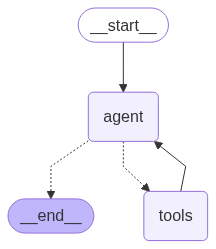

In [ ]:
from IPython.display import Image, display
display(Image(execution_agent.get_graph().draw_mermaid_png()))

In [ ]:
task = "Write a strategic one-pager of building an AI startup"
result = await graph.ainvoke({"task": task})

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
print(result["final_response"].content)

In [ ]:
async for output in graph.astream({"task": task}, stream_mode="updates"):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

# Installation

In [ ]:
!pip install langchain_google_vertexai langsmith langchain-google-genai duckduckgo-search langchain-community langgraph arxiv wikipedia ddgs

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 M